In [ ]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
import pandas as pd
import numpy as np
import math
from tensorflow import keras
from keras.callbacks import EarlyStopping


In [2]:
# Definir la métrica SSIM
def ssim_metric(y_true, y_pred):
    y_true = tf.clip_by_value(y_true, 0, 1)
    y_pred = tf.clip_by_value(y_pred, 0, 1)
    ssim_value = tf.map_fn(lambda x: tf.image.ssim(x[0], x[1], max_val=1.0), (y_true, y_pred), dtype=tf.float32)
    return tf.reduce_mean(ssim_value)

# Definir la métrica PSNR
def psnr_metric(y_true, y_pred):
    y_true = tf.clip_by_value(y_true, 0, 1)
    y_pred = tf.clip_by_value(y_pred, 0, 1)
    psnr_value = tf.image.psnr(y_true, y_pred, max_val=1.0)
    return tf.reduce_mean(psnr_value)

In [3]:
# Ruta de los archivos DICOM
path_files = '/Users/charlesdaza/Downloads/IDA/PPMI/3D/1.5 Tesla/Sagital'
files_dcm = []

# Recorrer todas las carpetas y subcarpetas
for root, dirs, files in os.walk(path_files):
    images_dcm = [os.path.join(root, file) for file in files if file.endswith('.dcm')]
    images_dcm.sort(key=lambda x: int(pydicom.dcmread(x).InstanceNumber))
    files_dcm.extend(images_dcm)

# Comprobar la cantidad de archivos DICOM encontrados
print(f"Total de archivos DICOM encontrados: {len(files_dcm)}")

# Cargar imágenes que son exactamente de 256x256
images_mri = []
for archivo in files_dcm:
    img = pydicom.dcmread(archivo).pixel_array
    if img.shape == (256, 256):
        images_mri.append(img.astype(np.float32) / 255.0)  # Normalizar a [0, 1]

print(f"Total de imágenes de 256x256 encontradas: {len(images_mri)}")

if images_mri:
    high_img_mri = np.stack(images_mri, axis=0)
    print(f"Forma del volumen de imágenes: {high_img_mri.shape}")
else:
    print("No se encontraron imágenes de 256x256.")

Total de archivos DICOM encontrados: 55858
Total de imágenes de 256x256 encontradas: 31474
Forma del volumen de imágenes: (31474, 256, 256)


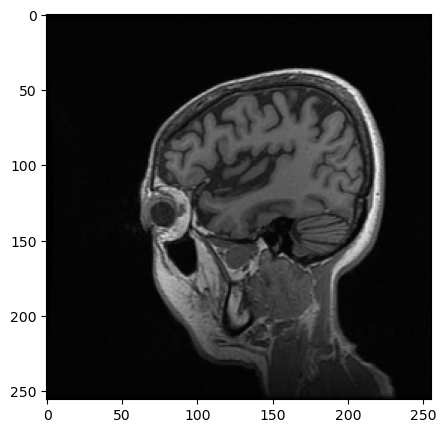

In [4]:
# Ver imágenes de resonancia magnética
plt.figure(figsize=(5, 5))
plt.imshow(high_img_mri[870], cmap='gray')

Forma de las imágenes de baja resolución: (31474, 256, 256)


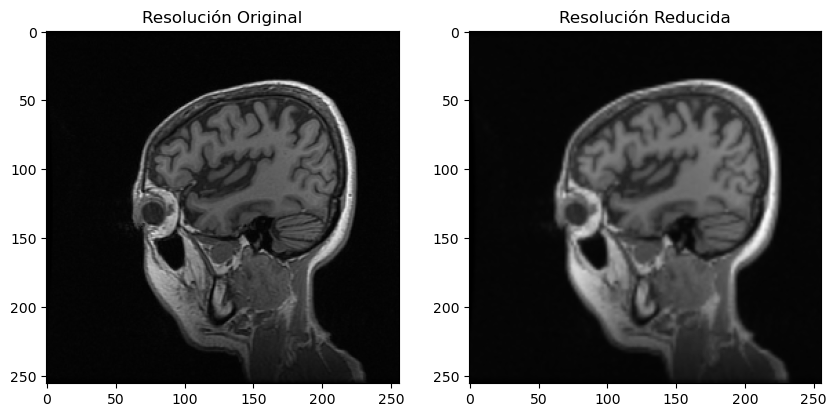

In [5]:
# Reducir resolución
def low_res_image(images, factor):
    if images is None or len(images) == 0:
        print("No hay imágenes válidas para procesar.")
        return None

    # Normalizar y procesar imágenes en un solo paso
    low_res_images = [
        cv2.resize(
            cv2.resize(image.astype(np.float32), 
                       (int(image.shape[1] * factor), int(image.shape[0] * factor)), 
                       interpolation=cv2.INTER_AREA),
            (image.shape[1], image.shape[0]), 
            interpolation=cv2.INTER_LINEAR
        ) / 255.0
        for image in images if image is not None and image.size > 0
    ]

    if not low_res_images:
        print("No se generaron imágenes de baja resolución.")
        return None

    return np.stack(low_res_images, axis=0)

# Factor de reducción de resolución
factor_res = 0.5

# Verificar si las imágenes de entrada son válidas
if high_img_mri is not None and high_img_mri.size > 0:
    low_img_mri = low_res_image(high_img_mri, factor_res)
    if low_img_mri is not None:
        print(f"Forma de las imágenes de baja resolución: {low_img_mri.shape}")
else:
    print("No hay imágenes válidas para procesar.")

# Visualización de una imagen de alta y baja resolución
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(high_img_mri[870], cmap='gray')
plt.title('Resolución Original')
plt.subplot(1, 2, 2)
plt.imshow(low_img_mri[870], cmap='gray')
plt.title('Resolución Reducida')
plt.show()

In [6]:
# Tamaño de las imágenes después del preprocesamiento
SIZE = 256

# Definir porcentajes para división de datos
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Total de imágenes
total_images = len(high_img_mri)

# Calcular índices para dividir los datos
train_end = int(total_images * train_ratio)
validation_end = train_end + int(total_images * validation_ratio)

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
train_high_mri, train_low_mri = high_img_mri[:train_end], low_img_mri[:train_end]
validation_high_mri, validation_low_mri = high_img_mri[train_end:validation_end], low_img_mri[train_end:validation_end]
test_high_mri, test_low_mri = high_img_mri[validation_end:], low_img_mri[validation_end:]

# Añadir una dimensión para cumplir con el formato de entrada del modelo
def add_channel_dimension(images):
    return np.reshape(images, (len(images), SIZE, SIZE, 1))

train_high_mri = add_channel_dimension(train_high_mri)
train_low_mri = add_channel_dimension(train_low_mri)
validation_high_mri = add_channel_dimension(validation_high_mri)
validation_low_mri = add_channel_dimension(validation_low_mri)
test_high_mri = add_channel_dimension(test_high_mri)
test_low_mri = add_channel_dimension(test_low_mri)

# Imprimir las formas de los conjuntos de datos
print("Shape of training mri:", train_high_mri.shape)
print("Shape of validation mri:", validation_high_mri.shape)
print("Shape of test mri:", test_high_mri.shape)

# Definir el modelo de downsample
def down(filters, kernel_size, apply_batch_normalization=True):
    downsample = tf.keras.models.Sequential([
        layers.Conv2D(filters, kernel_size, padding='same', strides=2),
        layers.BatchNormalization() if apply_batch_normalization else layers.Activation('linear'),
        layers.LeakyReLU()
    ])
    return downsample

# Definir el modelo de upsample
def up(filters, kernel_size, dropout=False):
    upsample = tf.keras.models.Sequential([
        layers.Conv2DTranspose(filters, kernel_size, padding='same', strides=2),
        layers.Dropout(0.2) if dropout else layers.Activation('linear'),
        layers.LeakyReLU()
    ])
    return upsample

Shape of training mri: (25179, 256, 256, 1)
Shape of validation mri: (3147, 256, 256, 1)
Shape of test mri: (3148, 256, 256, 1)


In [7]:
# Parámetros del modelo
low_res_image_height, low_res_image_width = 256, 256
channels = 1  # Escala de grises

# Definición del modelo
model = keras.Sequential([
    # Layer 1 - ConvNet
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(low_res_image_height, low_res_image_width, channels)),
    keras.layers.MaxPooling2D((2, 2)),

    # Layer 2 - Upsampling
    keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear'),

    # Layer 3 - ConvNet
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),

    # Capa adicional para mejorar el PSNR
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Capa adicional

    # Capa adicional 2 para mejorar el PSNR
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Capa adicional 2

    # Capa adicional 3 para mejorar el PSNR
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Capa adicional 3

    # Layer 4 - Fusion
    keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')  # Salida de un solo canal
])

# Compilar el modelo con PSNR y SSIM como métricas
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='mean_absolute_error',
    metrics=[ssim_metric, psnr_metric] 
)

# Resumen del modelo
model.summary()

/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-25 22:50:46.680247: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-05-25 22:50:46.680381: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-05-25 22:50:46.680395: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-05-25 22:50:46.680593: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-25 22:50:46.680607: I tensorflow/core/common_runtime/pluggable_device/pluggable_device

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,177 (508.50 KB)

 Trainable params: 130,177 (508.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from datetime import datetime
# Ver la hora de inicio del entrenamiento
start_time = datetime.now()
print(f"Entrenamiento comenzó a las: {start_time.strftime('%H:%M:%S')}")

Entrenamiento comenzó a las: 22:50:47


In [9]:
history = model.fit(train_low_mri, train_high_mri, 
                    epochs=30,
                    batch_size=32, 
                    validation_data=(validation_low_mri, validation_high_mri))

Epoch 1/30
Instructions for updating:
Use fn_output_signature instead


2025-05-25 22:51:05.401950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


787/787 ━━━━━━━━━━━━━━━━━━━━ 439s 554ms/step - loss: 0.5988 - psnr_metric: 15.9871 - ssim_metric: 0.3627 - val_loss: 0.4317 - val_psnr_metric: 23.8733 - val_ssim_metric: 0.5924
Epoch 2/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 455s 576ms/step - loss: 0.4580 - psnr_metric: 23.3407 - ssim_metric: 0.6130 - val_loss: 0.4271 - val_psnr_metric: 24.9999 - val_ssim_metric: 0.6571
Epoch 3/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 457s 580ms/step - loss: 0.4582 - psnr_metric: 24.3827 - ssim_metric: 0.6633 - val_loss: 0.4235 - val_psnr_metric: 25.7739 - val_ssim_metric: 0.7010
Epoch 4/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 455s 578ms/step - loss: 0.4383 - psnr_metric: 25.4315 - ssim_metric: 0.7012 - val_loss: 0.4215 - val_psnr_metric: 26.4414 - val_ssim_metric: 0.7254
Epoch 5/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 452s 574ms/step - loss: 0.4446 - psnr_metric: 25.8766 - ssim_metric: 0.7193 - val_loss: 0.4205 - val_psnr_metric: 26.7985 - val_ssim_metric: 0.7388
Epoch 6/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 455s 579ms/step - loss: 0.4476 

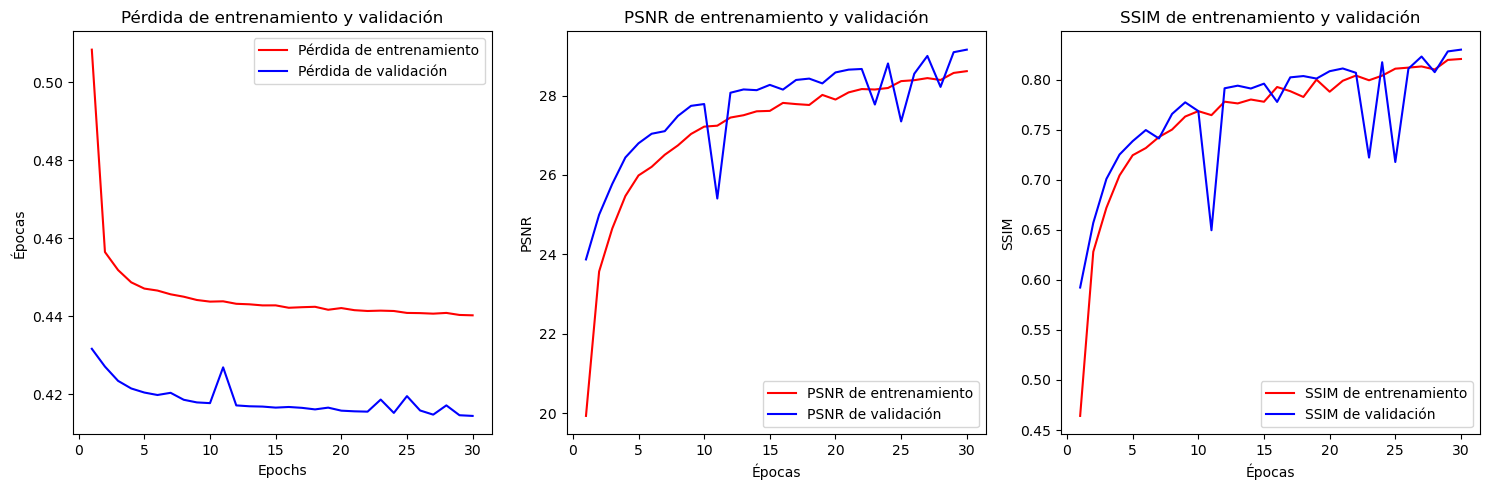

In [ ]:

# Obtener las métricas del historial de entrenamiento
loss = history.history['loss']
val_loss = history.history['val_loss']
psnr = history.history['psnr_metric']
val_psnr = history.history['val_psnr_metric']
ssim = history.history['ssim_metric']
val_ssim = history.history['val_ssim_metric']

epochs = range(1, len(loss) + 1)

# Crear una figura con 3 subgráficas en una fila
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Graficar la pérdida
axs[0].plot(epochs, loss, 'r', label='Pérdida de entrenamiento')
axs[0].plot(epochs, val_loss, 'b', label='Pérdida de validación')
axs[0].set_title('Pérdida de entrenamiento y validación')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Épocas')
axs[0].legend()

# Graficar el PSNR
axs[1].plot(epochs, psnr, 'r', label='PSNR de entrenamiento')
axs[1].plot(epochs, val_psnr, 'b', label='PSNR de validación')
axs[1].set_title('PSNR de entrenamiento y validación')
axs[1].set_xlabel('Épocas')
axs[1].set_ylabel('PSNR')
axs[1].legend()

# Graficar el SSIM
axs[2].plot(epochs, ssim, 'r', label='SSIM de entrenamiento')
axs[2].plot(epochs, val_ssim, 'b', label='SSIM de validación')
axs[2].set_title('SSIM de entrenamiento y validación')
axs[2].set_xlabel('Épocas')
axs[2].set_ylabel('SSIM')
axs[2].legend()

# Ajustar el layout
plt.tight_layout()
plt.show()

In [11]:

# Evaluación en el conjunto de validación
loss, psnr_value, ssim_value = model.evaluate(validation_low_mri, validation_high_mri)
print(f"Loss: {loss}")
print(f"PSNR: {ssim_value}")
print(f"SSIM: {psnr_value}")


99/99 ━━━━━━━━━━━━━━━━━━━━ 29s 294ms/step - loss: 0.3082 - psnr_metric: 29.7041 - ssim_metric: 0.8560
Loss: 0.4145066738128662
PSNR: 29.15740966796875
SSIM: 0.8302294015884399


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


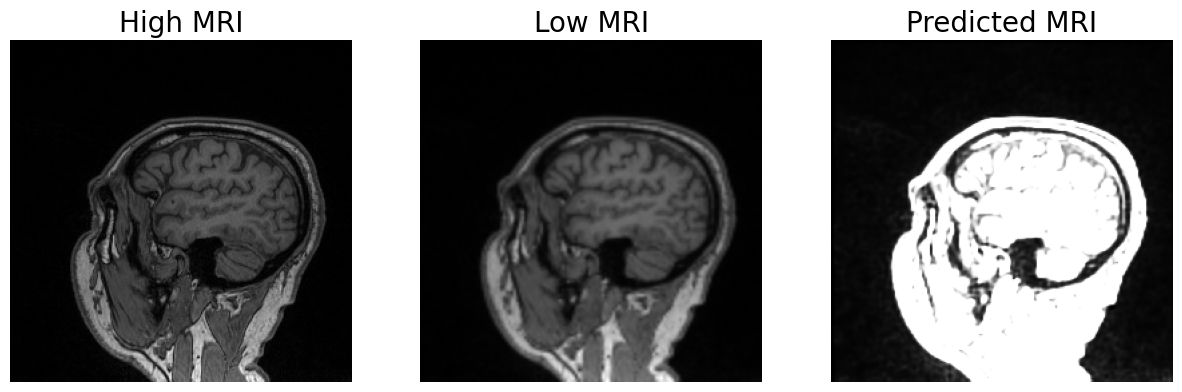

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


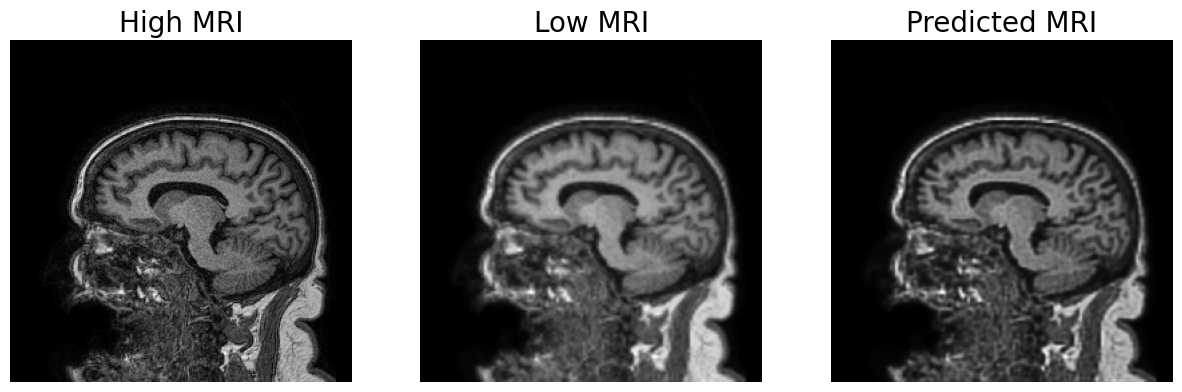

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


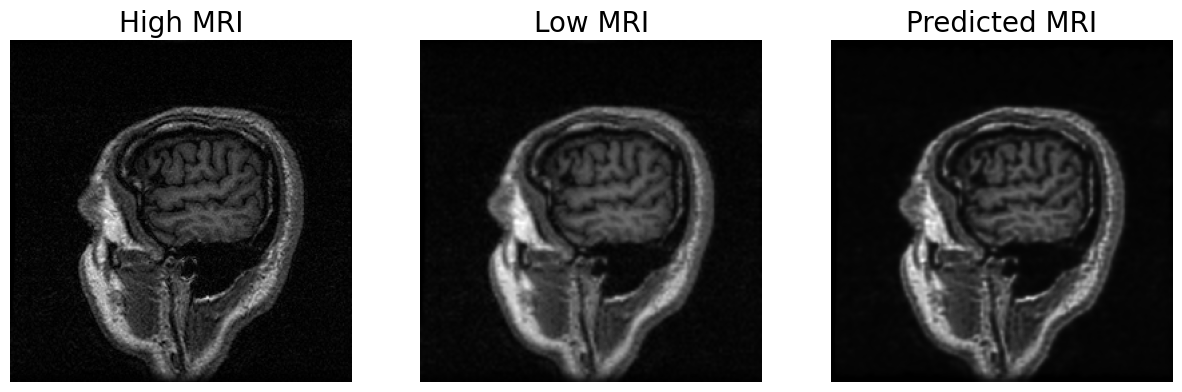

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


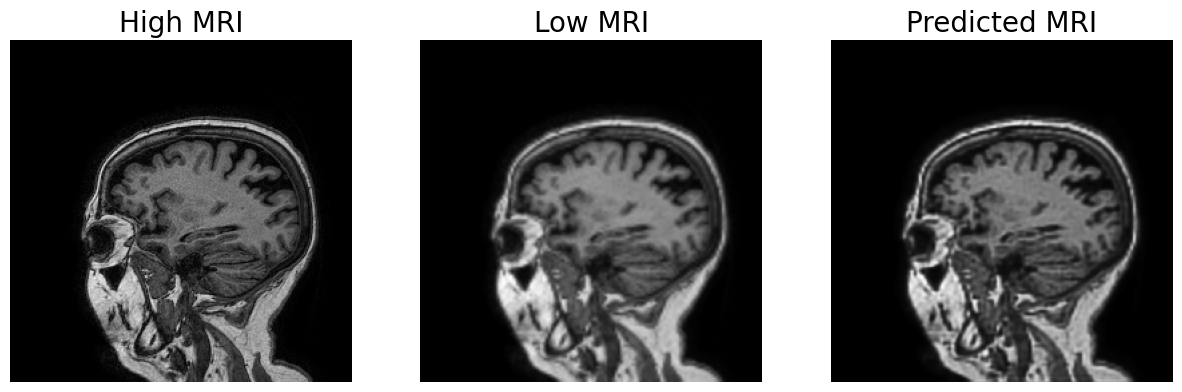

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


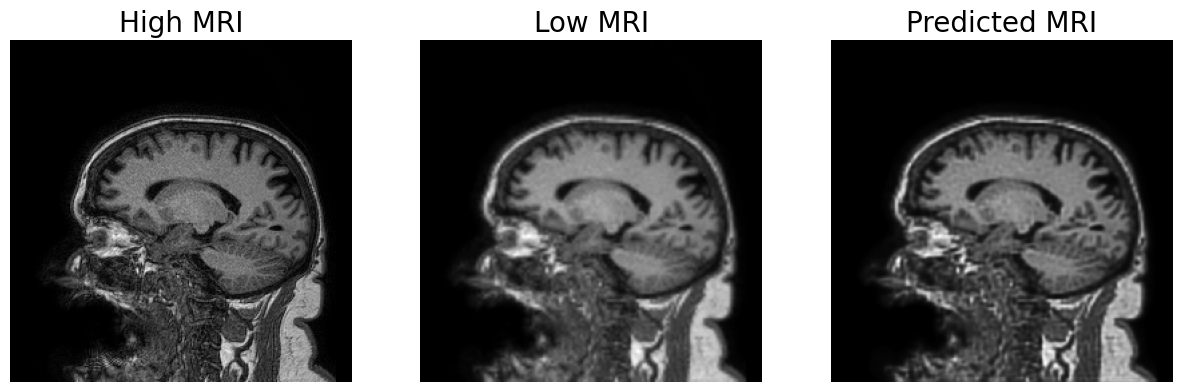

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


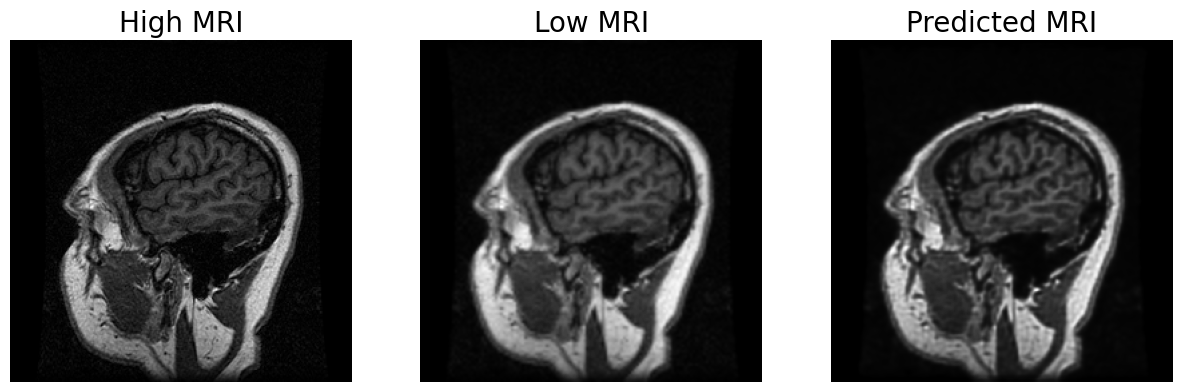

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


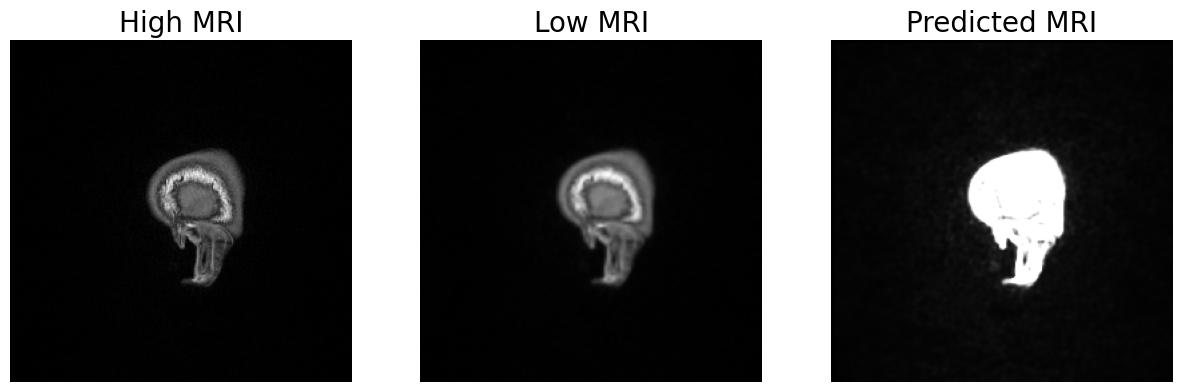

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


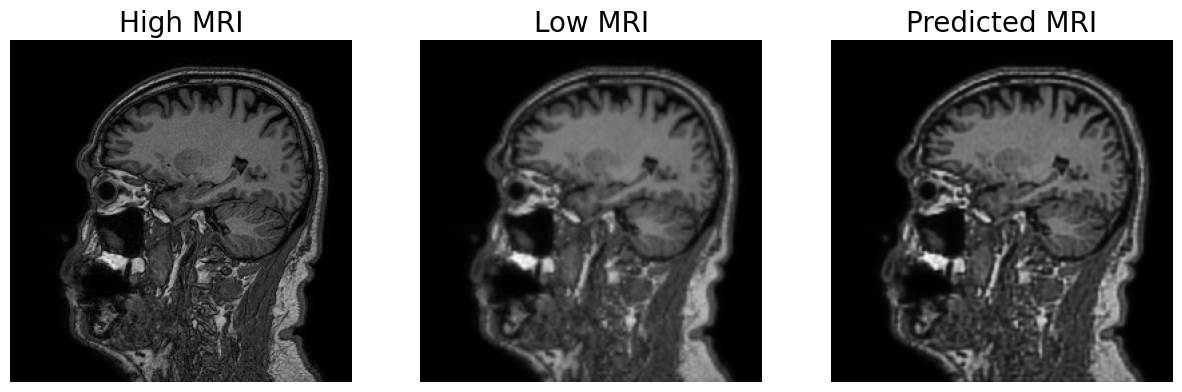

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


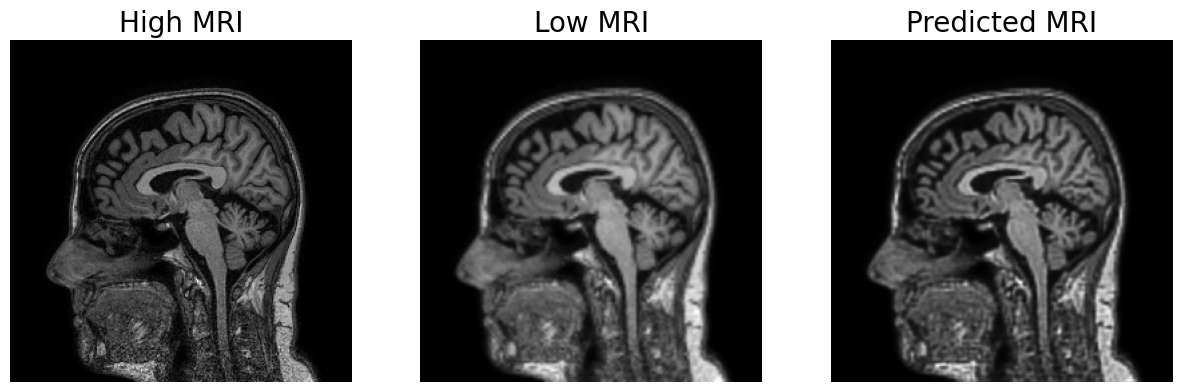

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


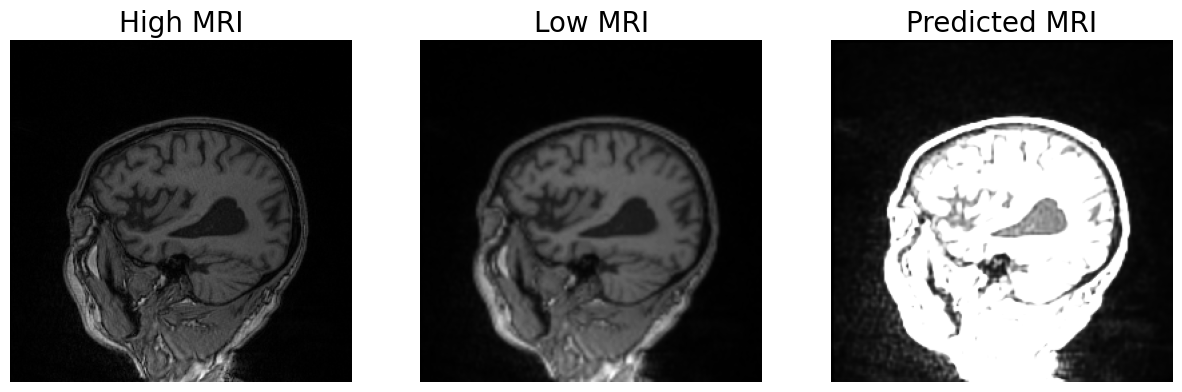

   Número de Imagen     PSNR    SSIM     MSE
0              3105  51.5293  0.5869  0.4572
1              2302  78.7735  0.9747  0.0009
2                24  86.2222  0.9828  0.0002
3               285  78.6514  0.9808  0.0009
4              2326  78.7901  0.9763  0.0009
5              2770  83.9159  0.9869  0.0003
6              2385  59.5338  0.6962  0.0724
7              2663  75.4681  0.9682  0.0018
8              1689  78.1954  0.9642  0.0010
9               192  53.0538  0.6560  0.3219


In [ ]:
import random
# Comparativa imágenes
def psnr(target, ref):
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    diff = ref_data - target_data
    rmse = math.sqrt(np.mean(diff**2.))
    if rmse == 0:
        return float('inf')
    return 20 * math.log10(255. / rmse)

def ssim(target, ref):
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    target = target.astype(np.float64)
    ref = ref.astype(np.float64)

    mu1 = np.mean(target)
    mu2 = np.mean(ref)
    sigma1 = np.std(target)
    sigma2 = np.std(ref)
    sigma12 = np.mean((target - mu1) * (ref - mu2))

    ssim_value = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / ((mu1 ** 2 + mu2 ** 2 + C1) * (sigma1 ** 2 + sigma2 ** 2 + C2))
    return ssim_value

def mae(target, ref):
    return np.mean(np.abs(ref - target))

def mse(target, ref):
  return np.mean((ref.astype(np.float64) - target.astype(np.float64)) ** 2)

def compare_images(target, ref):
    target = np.clip(target, 0, 255)
    ref = np.clip(ref, 0, 255)
    # Si es necesario, elimina el canal extra
    if target.ndim == 3 and target.shape[-1] == 1:
        target = target.squeeze(-1)
    if ref.ndim == 3 and ref.shape[-1] == 1:
        ref = ref.squeeze(-1)
    psnr_score = psnr(target, ref)
    ssim_score = ssim(ref, target)
    mse_score = mse(ref, target)
    return [psnr_score, ssim_score, mse_score]

def plot_images(high, low, predicted):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('High MRI', color='black', fontsize=20)
    plt.imshow(high, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Low MRI', color='black', fontsize=20)
    plt.imshow(low, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Predicted MRI', color='black', fontsize=20)
    plt.imshow(predicted, cmap='gray')
    plt.axis('off')
    plt.show()

# Lista para almacenar los resultados como diccionarios
results_data = []
indices = list(range(len(test_low_mri)))
random.shuffle(indices)

# Iterar sobre una muestra de índices
for i in indices[:10]:
    # Realizar la predicción
    predicted = model.predict(test_low_mri[i].reshape(1, SIZE, SIZE, 1))
    
    # Procesar la imagen predicha
    pred_img = predicted[0].squeeze()
    pred_img = np.clip(pred_img, 0, 255)
    
    # Comparar imágenes y obtener scores
    score = compare_images(pred_img, test_high_mri[i])
    
    # Almacenar el número de imagen y los scores en un diccionario
    results_data.append({
        'Número de Imagen': i,  
        'PSNR': score[0],
        'SSIM': score[1],
        'MSE': score[2]
    })
    
    # Mostrar imágenes
    plot_images(test_high_mri[i], test_low_mri[i], pred_img)

# Crear DataFrame de resultados a partir de la lista de diccionarios
df_scores = pd.DataFrame(results_data)


df_scores = df_scores[['Número de Imagen', 'PSNR', 'SSIM', 'MSE']]
df_scores = df_scores.round(4)
# Mostrar el DataFrame
print(df_scores)

In [14]:
# Obtener la hora de finalización del entrenamiento
end_time = datetime.now()
print(f"Entrenamiento finalizado a las: {end_time.strftime('%H:%M:%S')}")

# Calcular el tiempo total de entrenamiento
total_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {total_time}") 

Entrenamiento finalizado a las: 02:31:55
Tiempo total de entrenamiento: 3:41:07.647026


In [15]:
# Guardar el modelo en un archivo HDF5
model.save('modelo_autoencoder.h5')